In [16]:
import datalog  as dl
import pandas as pd
import numpy as np

data = dl.wpilog_to_json('/home/jbuist/Documents/DataLog/FRC_20220328_233226.wpilog')
df = pd.DataFrame(data)
# Remove the standard data fields, only keeping our custom data.
df = df[df['name'].apply(lambda x: not x.startswith('NT:/') and x != 'NTConnection' and x != 'messages')]
# Verify we've got only what we need
df['name'].unique()

array(['target X', 'target Y', 'pose X', 'pose Y', 'error X', 'error Y',
       'target heading', 'pose heading'], dtype=object)

In [17]:
# Now we create a rownum column that will take every variable we're logging,
# group them together and internally sort that group by the timestamp value and
# create an increasing row number for each group.
# This in effect ranks the first target X witha rownum=1, the first target Y with a rownum=1
# and so on down the line of columns, then rownum=2 contains the second value for each variable.
df['rownum'] = df.sort_values(by='timestamp').groupby('name').cumcount() + 1

# Now for each rownum we create new columns that shows us the minimum, or
# first timestamp value in that rownum as well as max/last and the difference
# between them. If the time difference is too large (subjective) we might want to consider
# dropping an incomplete row of data or adjusting our technique for lining them up.
df['mints'] = df.groupby('rownum')['timestamp'].transform('min')
df['maxts'] = df.groupby('rownum')['timestamp'].transform('max')
df['diffts'] = df['maxts'] - df['mints']

# Look for the rows with the largest difference.
# (This is how I figured out we should drop messages from the data)
timecheck_df = df.sort_values(by='diffts', ascending=False)
timecheck_df

,name,type,timestamp,value,rownum,mints,maxts,diffts
44624,pose heading,double,38.855584,32.48459,250,36.907225,38.855584,1.948359
44623,target heading,double,38.855580,30.0,250,36.907225,38.855584,1.948359
42376,error Y,double,36.907247,0.414697,250,36.907225,38.855584,1.948359
42375,error X,double,36.907243,1.261062,250,36.907225,38.855584,1.948359
42374,pose Y,double,36.907240,74.603087,250,36.907225,38.855584,1.948359
...,...,...,...,...,...,...,...,...
56255,pose Y,double,43.834760,29.795751,751,43.834748,43.834767,0.000019
56254,pose X,double,43.834756,121.375832,751,43.834748,43.834767,0.000019
56253,target Y,double,43.834753,77.396764,751,43.834748,43.834767,0.000019
56252,target X,double,43.834748,260.368931,751,43.834748,43.834767,0.000019


In [18]:
# Currently the df dataframe has a single 'name' column and a single 'value' column
# that is a mix of everything we're measuring. Here we take each value for 'name'
# (target X, target Y, etc.. ) and turn them into a column with ther row's 'value'
# as the value of the cell
pivot_df = df.pivot(index='rownum', columns='name', values='value')
pivot_df


name,error X,error Y,pose X,pose Y,pose heading,target X,target Y,target heading
rownum,,,,,,,,
1,0.0,0.0,297.207763,30.578064,79.280105,297.207763,30.578064,45.0
2,0.006822,-0.016486,297.207763,30.578064,79.278564,297.214585,30.561578,45.0
3,0.012543,-0.023676,297.207763,30.578064,79.278289,297.220306,30.554388,45.0
4,0.017164,-0.021571,297.207763,30.578064,79.278289,297.224927,30.556492,45.0
5,0.020684,-0.010172,297.207763,30.578064,79.281234,297.228447,30.567892,45.0
...,...,...,...,...,...,...,...,...
748,135.230892,46.93751,119.052193,31.031336,44.3799,254.283085,77.968846,45.0
749,136.473119,47.16176,119.829566,30.620487,44.3799,256.302685,77.782247,45.0
750,137.731726,47.381493,120.599576,30.210056,NaN,258.331302,77.591549,NaN


In [19]:
# Trim our original dataframe down to just the rownum and timestamp values
ts_df = df[['rownum', 'mints', 'maxts', 'diffts']]
ts_df = ts_df.drop_duplicates()

# Join the timestamp data back to our pivoted dataset so we've got that available in a single dataframe
# The ts_df dataframe is basically a spreadsheet with rownum and the timestamp values for each as the columns
# The pivot_df also contains the same rownum value, but it is already naturally its index
# and Panads joins on indexes without fuss, so we index the ts_df to the rownum column it has
# and let pandas join them up. Think of it like making two spreadsheets and copying and pasting
# them together and it works because they're ordered the same way with the same number of rows.
full_df = ts_df.set_index('rownum').join(pivot_df)

# Fill forward any NaN (null) values that are still in the data. This basically says to
# use the last known value for a column, like target X, if NaN was reported in this time slot
full_df = full_df.ffill()
full_df

,mints,maxts,diffts,error X,error Y,pose X,pose Y,pose heading,target X,target Y,target heading
rownum,,,,,,,,,,,
1,34.417573,34.417697,0.000124,0.000000,0.000000,297.207763,30.578064,79.280105,297.207763,30.578064,45.0
2,34.427204,34.427265,0.000061,0.006822,-0.016486,297.207763,30.578064,79.278564,297.214585,30.561578,45.0
3,34.437181,34.437241,0.000060,0.012543,-0.023676,297.207763,30.578064,79.278289,297.220306,30.554388,45.0
4,34.447209,34.447267,0.000058,0.017164,-0.021571,297.207763,30.578064,79.278289,297.224927,30.556492,45.0
5,34.457151,34.457210,0.000059,0.020684,-0.010172,297.207763,30.578064,79.281234,297.228447,30.567892,45.0
...,...,...,...,...,...,...,...,...,...,...,...
748,43.805180,43.834788,0.029608,135.230892,46.937510,119.052193,31.031336,44.379900,254.283085,77.968846,45.0
749,43.815434,43.845145,0.029711,136.473119,47.161760,119.829566,30.620487,44.379900,256.302685,77.782247,45.0
750,43.825044,43.825064,0.000020,137.731726,47.381493,120.599576,30.210056,44.379900,258.331302,77.591549,45.0


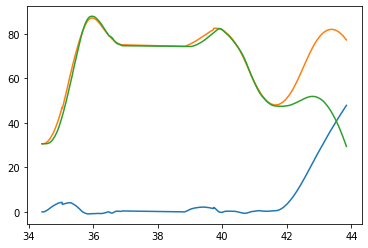

In [27]:
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 100)

#plt.plot(full_df['target X'], full_df['target Y'])
plt.plot(full_df['mints'], full_df['error X'])
plt.plot(full_df['mints'], full_df['target X'])
plt.plot(full_df['mints'], full_df['pose X'])
"""
plt.plot(full_df['mints'], full_df['error Y'])
plt.plot(full_df['mints'], full_df['target Y'])
plt.plot(full_df['mints'], full_df['pose Y'])
"""
plt.show()
